## Function definition

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils
import math
from scipy.interpolate import RegularGridInterpolator
import time
from PIL import Image

def eucl_dist(p):
    return np.sqrt(np.square(p[0, :])+ np.square(p[1, :]))

def delta_r(p, dist):
    p = eucl_dist(p)
    return dist[0]*p**2 + dist[1]*p**4 + dist[2]*p**8

def radial_dist(p, dist):
    return p*(1+delta_r(p, dist))

def box3d(n):
    x = []
    y = []
    z = []

    for i, val in enumerate([-0.5, -0.5, 0, 0.5, 0.5], 1):
        x = np.concatenate((x, val*np.ones(n)))
        y = np.concatenate((y, np.linspace(-0.5, 0.5, n)))
        z = np.concatenate((z, (2*(i % 2)-1)*val*np.ones(n)))
    x2 = np.concatenate((x, y))
    x2 = np.concatenate((x2, x))
    y2 = np.concatenate((y, z))
    y2 = np.concatenate((y2, z))
    z2 = np.concatenate((z, x))
    z2 = np.concatenate((z2, y))
    return np.vstack((x2, y2, z2))


def projectpoints(K, R, t, Q):
    #ret = K@np.concatenate((R, t))@np.hstack((P, 1))
    ret = K@np.hstack((R, t))@np.vstack((Q, np.ones(len(Q[0]))))
    return ret[0:2, :]/ret[2, :]

def projectpoints2(K, R, t, Q, dist):

    RtQ_homo = np.hstack((R, t))@np.vstack((Q, np.ones(len(Q[0]))))
    RtQ_inhomo = RtQ_homo[0:2, :]/RtQ_homo[2, :]
    rad_dist = radial_dist(RtQ_inhomo, dist)
    rad_dist_homo = np.vstack((rad_dist, np.ones(len(rad_dist[0]))))
    return K@rad_dist_homo

def to_inhomogeneous(q):
    return q[0:2, :]/q[2, :]

def format_H_to_solution(H):
    return H*(-2/H[0][0])


## Exercise 2.1
Adding soem extra parameters to camera matrix (alpha, beta, delta_x, delta_y)

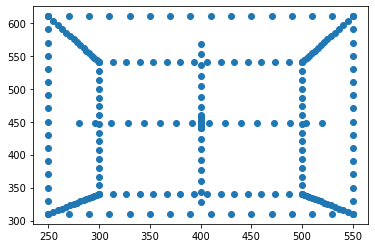

In [21]:
Q = box3d(16)
f = 600
alpha = 1
beta = 0
delta_x = delta_y = 400
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
R = np.identity(3)
t = np.array([[0, 0.2, 2.5]]).T
camera = projectpoints(K, R, t, Q)
plt.scatter(camera[0], camera[1])
plt.show()
# y = distance from the object
# z = distance from the object into the table
# x = distance to left

## Exercise 2.2
Implementing distortino function

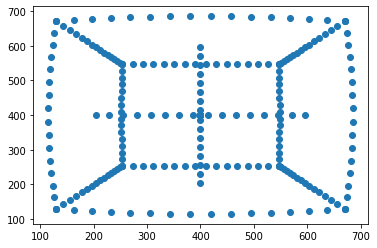

In [22]:
Q = box3d(16)
f = 600
alpha = 1
beta = 0
delta_x = delta_y = 400
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
R = np.identity(3)
t = np.array([[0, 0, 1.5]]).T
k3 = -0.2
k5 = 0
k7 = 0
dist = np.array([k3, k5, k7])
camera = projectpoints2(K, R, t, Q, dist)
plt.scatter(camera[0], camera[1])
plt.show()

## Exercise 2.3
Finding the camera matrix for the gopro image.

In [23]:
image = cv2.imread("gopro_robot.jpg")
new_image = cv2.imread("black.jpg")
image = cv2.resize(image, (480, 270))
new_image = cv2.resize(new_image, (480, 270))
(h, w, d) = image.shape

delta_x = w/2  # principal point should be in the middle
delta_y = h/2
alpha = 1
beta = 0
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
print("Camera Matrix")
print(K)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


## Exercise 2.4
This one was the most tricky. Firstly I misunderstood that we actually have the pixels, not the position in meters, so I wrongly implemented it to the opposite side of the equation. to get the results, there are two options.
1) Inverse the whole logic of the equation which is used for computing the distorin (which includes inversing the dist() function. It might be working, but it would take ages to do it. Therefore the more clever idea is probably the next option
2) Use bilinear interpolation by running scipy.interpolate.RegularGridInterpolator. Havent tried yet, but might give a try later. Nevertheless, its just premade function which wont give much of the value to implement. Its more likely just about finding the right arguments in the function call...

This is the working code by Henrik. To use it, you make a grid of the coordinates that you want to query.  What I do right now is what we discussed on friday: so I map a distorted point-map to the distorted image and then sample the image onto a non-distorted map, like this:

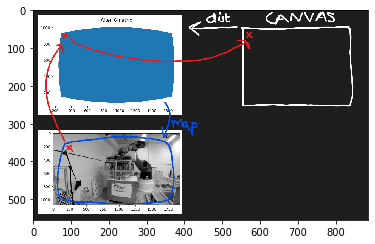

In [ ]:
brg = cv2.imread("henrik.png")
b,g,r = cv2.split(brg)       # get b,g,r
new_image = cv2.merge([r,g,b])
plt.imshow(new_image)

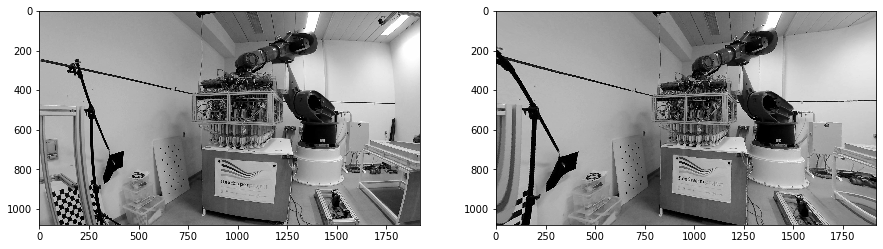

In [ ]:
import matplotlib.cm as cm

def undistortImage(gray, K, dist):
    """
    Undistorts an image by mapping the colors a new empty image.
    TODO: Assumes image is one single channel.
    """
    (height,width) = gray.shape
    ratio = height/width
    # Generate meshgrid of all pixels.
    scale = 1.2
    y, x = np.meshgrid(
        np.linspace(-scale, scale, num=width), np.linspace(-scale*ratio, scale*ratio, num=height))
    x=x.flatten()
    y=y.flatten()
    mapping_matrix = np.vstack((x, y)).astype(float) # [x, y]

    # Distort the grid
    p = radial_dist(mapping_matrix, dist)

    q = np.vstack((p, np.ones(len(p[0]))))
    # Multiply by the camera matrix
    q = K@q
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    target_matrix = q[0:2, :]/q[2, :]

    # Target_matrix hold the distorted positions.
    canvas_matrix = np.zeros(shape=(int(height), int(width)), dtype=int)

    for i in range(height):
        for j in range(width):

            row = int(target_matrix[0][i*width + j]) 
            col = int(target_matrix[1][i*width + j])

            intensity = int(gray[row][col])
            canvas_matrix[i][j] = intensity

    return canvas_matrix

# Load image
image = cv2.imread('gopro_robot.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# The K matrix
(h, w) = gray.shape
f = int(0.455732 * w)
dx = int(0.5*h)
dy = int(0.5*w)
dist = np.array([-0.245031, 0.071524, -0.00994978])
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])

# Runnign the algorithm
canvas_matrix = undistortImage(gray, K, dist)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(gray, cmap=cm.gray)
ax2.imshow(canvas_matrix, cmap=cm.gray)

## Exercise 2.5
* Map the points p_i using the homography points p_1 -> p_4 on a plane
* q1 = H*q2

In [ ]:
def homography_point(H,q):
    q_ret = H@q
    p_ret = to_inhomogeneous(q_ret)
    return p_ret #inhomogeneous

H = np.array([[-2,0,1],[1,-2,0],[0,0,3]])
q2_1 = np.array([[1, 1, 1]]).T #first point, original image
q2_2 = np.array([[0, 3, 1]]).T
q2_3 = np.array([[2, 3, 1]]).T
q2_4 = np.array([[2, 4, 1]]).T
q1_1 = np.vstack((homography_point(H,q2_1),1)) #first point, result image (after applying H)
q1_2 = np.vstack((homography_point(H,q2_2),1))
q1_3 = np.vstack((homography_point(H,q2_3),1))
q1_4 = np.vstack((homography_point(H,q2_4),1))

q1 = np.hstack((q1_1,q1_2,q1_3,q1_4))
q2 = np.hstack((q2_1,q2_2,q2_3,q2_4))

print("q1")
print(q1)
print("q2")
print(q2)


q1
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]
q2
[[1 0 2 2]
 [1 3 3 4]
 [1 1 1 1]]


## Exercise 2.6
- Function hest, arg 2 sets of (q1 and q2), return estimated homography matrix
- we need at least 4 pairs of points to estimate homography
- https://learnopencv.com/homography-examples-using-opencv-python-c/
- SVD is finding the eigenvector with the smallest eigenvalue
- The solution of Ax = 0 where ||x||2 = 1 is found using SVD. x = v where the singular vector corresponds to the smallest singular value.
- matrix B is A in SVD
- flatten(H) is x in SVD
- we try to find x, which we transform into H

In [ ]:
def hest(q1,q2):
    #q1 = [[x20_original, x21_original],[y20_original, y21_original]]
    #q2 = [[x10_result, x11_result][y10_result, y11_result]] #first number which q, second which column
    #q1 = H@q2
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) #np.vstack((B0,B1))
    U,S,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))

    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (H.T)

def get_b(q1,q2):
    B = np.kron(q2[:,0], np.array([[0,-1,q1[1,0]],[1,0,-q1[0,0]],[-q1[1,0],q1[0,0],0]]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i], np.array([[0,-1,q1[1,i]],[1,0,-q1[0,i]],[-q1[1,i],q1[0,i],0]]))
        B = np.vstack((B,B_temp))
    return B

H = hest(q1,q2)

print("q1")
print(q1)
print("q2")
print(q2)
print("H")
print(format_H_to_solution(H).round(2))

q1
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]
q2
[[1 0 2 2]
 [1 3 3 4]
 [1 1 1 1]]
H
[[-2.  0.  1.]
 [ 1. -2. -0.]
 [-0. -0.  3.]]


## Exercise 2.7
- function normalize2d that finds transformation T such that q_ih = T@p_ih has mean [0,0] and standard deviation [1,1] for all q_i

In [ ]:
def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

q_norm,T = normalize2d(q1) #normalize all values in array
print(q_norm)
print(T)


[[ 0.30151134  1.50755672 -0.90453403 -0.90453403]
 [ 1.58820278 -0.85518611  0.12216944 -0.85518611]
 [ 1.          1.          1.          1.        ]]
[[1.80906807 0.         0.90453403]
 [0.         1.46603333 2.07688055]
 [0.         0.         1.        ]]


## Exercise 2.8
* apply the normalzie2d in the hest function

In [ ]:
def hest(q1,q2):
    #q1 = [[x10_result, x11_result][y10_result, y11_result]] #first number which q, second which column
    #q2 = [[x20_original, x21_original],[y20_original, y21_original]]
    #q1 = H@q2
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) #np.vstack((B0,B1))
    U,S,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (np.linalg.inv(T1)@H.T@T2.round(2))

def get_b(q1,q2):
    B = np.kron(q2[:,0], np.array([[0,-1,q1[1,0]],[1,0,-q1[0,0]],[-q1[1,0],q1[0,0],0]]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i], np.array([[0,-1,q1[1,i]],[1,0,-q1[0,i]],[-q1[1,i],q1[0,i],0]]))
        B = np.vstack((B,B_temp))
    return B

q1 = np.hstack((q1_1,q1_2,q1_3,q1_4))
q2 = np.hstack((q2_1,q2_2,q2_3,q2_4))
H = hest(q1,q2)

print("q1")
print(q1)
print("q2")
print(q2)
print("H")
print(format_H_to_solution(H).round(2))

q1
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]
q2
[[1 0 2 2]
 [1 3 3 4]
 [1 1 1 1]]
H
[[-2.   -0.    1.  ]
 [ 1.   -2.   -0.01]
 [ 0.   -0.    2.99]]


## Exercise 2.9
* generate 100 points knowing the H and then try to compute this H

In [ ]:
import random
H = np.array([[-2,0,1],[1,-2,0],[0,0,3]])

def yolo():
    return random.randint(1,5)

def random_generator(n):
    q = np.array([[yolo(), yolo(), yolo()]]).T
    for i in range (0,n):
        q = np.hstack((q,np.array([[yolo(), yolo(), yolo()]]).T))
    return q

def q1_from_q2_2D(q1):
    q2 = np.vstack((homography_point(H,np.array([q1[:,0]]).T),1))
    for i in range(1,len(q1[0])):
        q2 = np.hstack((q2,np.vstack((homography_point(H,np.array([q1[:,i]]).T),1))))
    return q2

q2 = random_generator(100)
q1 = q1_from_q2_2D(q2)
H = hest(q1,q2)
print("H")
print(format_H_to_solution(H).round(2))


H
[[-2.    0.    1.02]
 [ 1.   -2.01  0.  ]
 [-0.   -0.    3.02]]


## Exercise 2.10 + 2.11
* mandatory, I spent 14 hours solving the previoud exercises, I think its time to move on